In [ ]:
import os
import sys
sys.path.insert(0, '/tf')
import importlib

gpu_num = "" # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Import Sionna
import sionna
importlib.reload(sionna)

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility


%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, channel_capacity, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement


In [ ]:
from sionna.rt import RIS

In [ ]:
scene = load_scene("test_scenes/hallway/hallway.xml")

In [ ]:

print(f'size:{scene.size}' )
print(f'center:{scene.center}')


scene.remove("tx")
scene.remove("rx")
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=2,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=2,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

# Create transmitter
tx = Transmitter(name="tx",
                 position=[0,-7,2])

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
              position=[0,7,2],
              orientation=[0,0,0])

# Add receiver instance to scene
scene.add(rx)

tx.look_at(rx) # Transmitter points towards receiver
scene.frequency = 2.14e9 # in Hz; implicitly updates RadioMaterials

scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)


size:[10.02     20.04      5.020002]
center:[0.        0.        2.5000002]


In [ ]:
# Compute propagation paths
paths = scene.compute_paths(max_depth=1,
                            num_samples=30e6, scattering=False)  # Number of rays shot into directions defined
                                              # by a Fibonacci sphere, too few rays can
                                              # lead to missing paths

scene.preview(paths, show_devices=True, show_paths=True) # Use the mouse to focus on the visualized paths


Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

Shape of tau:  (1, 1, 1, 7)
Shape of a (1, 1, 2, 1, 2, 7, 1)


Text(0, 0.5, '$|a|$')

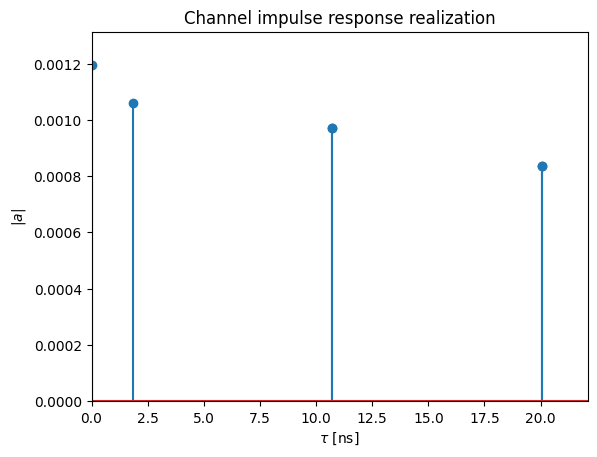

In [ ]:
a, tau = paths.cir()
print("Shape of tau: ", tau.shape)
print("Shape of a", a.shape)

t = tau[0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,0,:,0]
a_max = np.max(a_abs)
# Add dummy entry at start/end for nicer figure
t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])

# And plot the CIR
plt.figure()
plt.title("Channel impulse response realization")

plt.stem(t, a_abs)
plt.xlim([0, np.max(t)])
plt.ylim([-2e-6, a_max*1.1])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$")

In [ ]:
# Default parameters in the PUSCHConfig
subcarrier_spacing = 312.5e3
fft_size = 64
noise_floor = np.exp(0.1*(-174 + 10*np.log10(subcarrier_spacing) - 30))
                     
# Compute frequencies of subcarriers and center around carrier frequency
frequencies = scene.frequency + subcarrier_frequencies(fft_size, subcarrier_spacing)

# Compute the frequency response of the channel at frequencies.
h_freq = cir_to_ofdm_channel(frequencies,
                             a,
                             tau,
                             normalize=True) # Non-normalized includes path-loss

In [ ]:
print(h_freq.shape)

(1, 1, 2, 1, 2, 1, 64)


In [ ]:
capacity = channel_capacity(subcarrier_spacing,h_freq,noise_floor)

In [ ]:
print(capacity)

tf.Tensor([[[[40626512.]]]], shape=(1, 1, 1, 1), dtype=float32)


In [ ]:
print(scene.receivers["rx"].position)

tf.Tensor([0. 7. 2.], shape=(3,), dtype=float32)
